# Applied Mathematics 115: Mathematical Modeling  
---
*2024 Spring / Full Term*

**Meeting Time:**  
Tuesday 10:30 AM - 11:45 AM  
Thursday 10:30 AM - 11:45 AM
<br>
<br>

**Instructors:**  
*Michael P. Brenner* (Pierce Hall 313) brenner@seas.harvard.edu  
Francesco Mottes fmottes@seas.harvard.edu  

**Teaching Fellows:**  
Henry Bae henrybae@college.harvard.edu  
Sarah Martinson sarahmartinson@g.harvard.edu  
Shruti Sharma ssharma1@g.harvard.edu  
Al Shodiev alshodiev@college.harvard.edu  
Alex Sullivan alexsullivan@college.harvard.edu  
Matt Tibbitts mtibbitts@college.harvard.edu  





# Single elimination tournaments

In a single-elimination tournament, participants compete in a series of rounds, with each round consisting of matches between pairs of contestants. The loser of each match is immediately eliminated from the tournament, while the winner advances to the next round. This process continues until only one participant emerginges as the overall champion of the tournament. Single-elimination tournaments are commonly used in sports and other competitive events to determine a clear winner within a short period.

Taking inspiration from the previous models, we can imagine a vary basic way to model any tournament of this kind. Each two contestants $i$ and $j$ are associated with a probability $p_{ij}$ that contestant $i$ wins over contestant $j$ in a direct match. We then treat every direct match as a Bernoulli trial.

There are two major differences w.r.t. the Mosteller model we have seen before. The first (obvious) one is that each two teams play a single game against each other, the other is that the results of each elimination round affect the trials that are carried out in the successive round.

This makes it difficult to come up with a closed-form mathematical description of the probability of any team to win such competition. This is especially true if we want to include more and more effects, like home-field advantage or history-dependent probability of winning matches. The best option is then to simulate a lot of tournaments and come up with numerical estimates.

For a tournament with $n$ teams, the matrix $P=\{p_{ij}\}$ of pairwise probabilities of victory will have the form:

$$
\begin{bmatrix}
p_{11} & p_{12} & \cdots & p_{1n} \\
p_{21} & p_{22} & \cdots & p_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
p_{n1} & p_{n2} & \cdots & p_{nn} \\
\end{bmatrix}
$$


# Basic Model - 4 teams

We start by making two assumptions that simplify the model a lot.

The first one is that we are given a draw for the tournament, so the only stochasticity will be given by the results of the matches and not by the initial configuration of participants.

The second one is that the probabilities of winning matches are matched, that is $p_{ji} = 1-p_{ij}$. What this means in practice is that we are not accounting for possible effects related to the order of the draw and only which teams are playing matter. This need not apply, for example if you want to consider home advantage (home teams/players are usually listed first, so that $p_{ij}$ would mean "home game for team $i$"). If you consider home advantage, for example, then you would have $p_{ji} > 1 - p_{ij}$.

We consider a random draw, that will be fixed throughout the simulation. Then we generate some random probabilities of victory and simulate the tournament to estimate the proability of team $i$ winning the tournament.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

## Draw

In [21]:
N = 4 #number of teams

#generate random draw
draw = np.arange(N)
np.random.shuffle(draw)

#group teams 2 by 2
initial_matches = draw.reshape(2,-1).tolist()

print(initial_matches)

[[0, 3], [1, 2]]


## Pairwise Winning Probabilities

In [3]:
#generate random P matrix
P = np.random.uniform(size=(N,N))

#zero out lower part of the matrix
P = np.triu(P)

# set low triangular part to p_ji = 1-p_ij
P += np.tril(1-P.T)

#for sake of consistency, we set main diagonal to p_ii = 1-p_ii = .5 (has no practical effect)
P[np.diag_indices(P.shape[0])] = .5

print(P)

[[0.5        0.96766164 0.58211859 0.42833686]
 [0.03233836 0.5        0.11088723 0.82705837]
 [0.41788141 0.88911277 0.5        0.24722604]
 [0.57166314 0.17294163 0.75277396 0.5       ]]


We can also visualize the matrix of pairwise probabilities as a heatmap

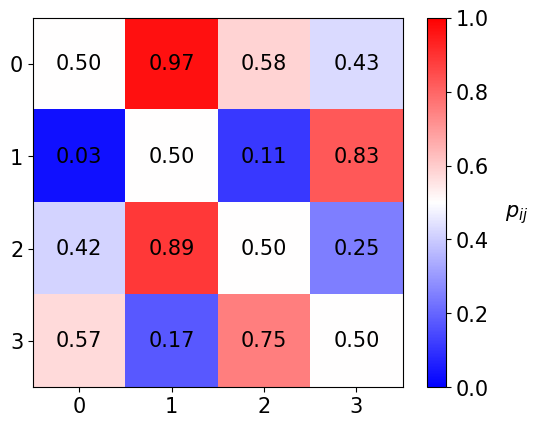

In [14]:
heatmap = plt.imshow(P, cmap='bwr', vmin=0., vmax=1.)

cbar = plt.colorbar()
cbar.set_label(r'$p_{ij}$', rotation=0, labelpad=20)

# Set integer ticks for both axes
plt.xticks(np.arange(N), np.arange(N))
plt.yticks(np.arange(N), np.arange(N))

for i in range(N):
    for j in range(N):
        plt.text(j, i, f'{P[i, j]:.2f}', ha='center', va='center', color='black')



## Tournament simulation

In [47]:
def simulate_4team_tournament(draw, P):
    '''
    Simple simulation of a tournament with 4 teams.

    Args
    ----

    draw : list[int]
            List of initial team pairings.
    P : np.ndarray
        Square matrix with pairwise winning probabilities.
    '''

    final = []

    #elimination rounds
    for i,j in draw:
        win_i = bool(np.random.uniform() < P[i,j])

        if win_i:
            final.append(i)
        else:
            final.append(j)

    #final
    i, j = final
    win_i = bool(np.random.uniform() < P[i,j])

    winner = i if win_i else j

    return [draw,final,winner]

In [48]:
simulate_4team_tournament(initial_matches, P)

[[[0, 3], [1, 2]], [0, 1], 0]

We can now simulate an ensemble of tournaments and record the results. We can then use these results to estimate the overall probability of a team winning the tournament given the current draw.

In [49]:
#counts occurrences of objects and returns dictionary with counts
from collections import Counter

n_trials = 1000

#carry out a number of simulated tournaments
winners = []
for _ in range(n_trials):
    _, _, winner = simulate_4team_tournament(initial_matches, P)
    winners.append(winner)


#count victories
dict_wins = Counter(winners)

In [50]:
dict_wins

Counter({3: 379, 0: 291, 2: 280, 1: 50})

In [51]:
#calculate and print winning probabilities
print('Tournament winning probabilities:')
print('---------------------------------\n')

for team in sorted(dict_wins):

    p = dict_wins[team] / n_trials

    print(f'Team {team}:\t{p:.3f}')

Tournament winning probabilities:
---------------------------------

Team 0:	0.291
Team 1:	0.050
Team 2:	0.280
Team 3:	0.379


## Effect of initial draw

We'll now use the code above to estimate the winning probability of each team for each of the possible initial draws.

It turns out that, unsurprisingly, the initial draw has a big impact on the overall probability of winning the tournament.

In [52]:
#for simplicity define a new function
def simulate_ensemble(draw, P, n_trials):

    #carry out a number of simulated tournaments
    winners = []
    for _ in range(n_trials):
        winner = simulate_4team_tournament(draw, P)[-1]
        winners.append(winner)

    #count victories
    dict_wins = Counter(winners)

    return dict_wins

In [53]:
possible_draws = [
    [[0,1],[2,3]],
    [[0,2],[1,3]],
    [[0,3],[1,2]]
]

In [73]:
#trials per draw
n_trials = 10000

team_p = {0:[], 1:[], 2:[], 3:[]}

for draw in possible_draws:
    d_wins = simulate_ensemble(draw, P, n_trials)

    #update p dict
    for team in d_wins:
        team_p[team] += [d_wins[team]/n_trials]

In [74]:
team_p

{0: [0.4579, 0.5095, 0.2666],
 1: [0.0194, 0.0529, 0.053],
 2: [0.1041, 0.3231, 0.28],
 3: [0.4186, 0.1145, 0.4004]}

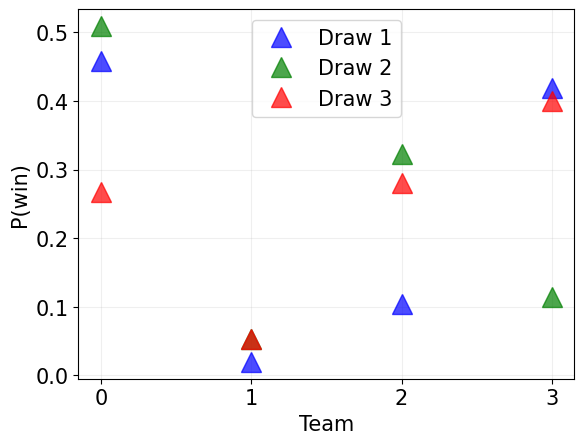

In [95]:
for team in team_p:
    for winp,color in zip(team_p[team],['b','g','r']):
        plt.plot([team],[winp], color+'^', markersize=15, alpha=.7)

plt.xticks(np.arange(N), np.arange(N))
plt.grid(alpha=.2)

plt.xlabel('Team')
plt.ylabel('P(win)')

#quick trick to add legend without repetitions (empty plots)
plt.plot([], [], 'b^', alpha=.7, markersize=15, label='Draw 1')
plt.plot([], [], 'g^', alpha=.7, markersize=15, label='Draw 2')
plt.plot([], [], 'r^', alpha=.7, markersize=15, label='Draw 3')

plt.legend(loc='upper center');

# (Stub) Estimate Pairwise Probabilities from Data

When modelling an actual tournament, we are usually given the initial draw or at least the partecipating teams. The information that's usually missing and that's at the core of the whole approach is, once again, the one about pairwise wining probabilities. For lack of better options, we can assume that these do not change too much in time and try to infer them from past matches between two teams.

The most crude approach is again to treat each past match as a bernoulli trial, then take the average of the results as the best approximation for $p_{ij}$.

In [130]:
# uncomment to clone gh repo easier access to data
!git clone https://github.com/fmottes/Harvard-AM115-2024.git

DATA_PATH = 'Harvard-AM115-2024/Homework/HW1/'

Cloning into 'Harvard-AM115-2024'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 7), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (33/33), 795.50 KiB | 8.84 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [131]:
import pandas as pd

#homework file with data
with open(DATA_PATH+'HW1-P4-Tournament4Teams_PrevMatches.csv', 'r') as fh:
    tournament_history = pd.read_csv(fh)

In [132]:
tournament_history

,TeamA,TeamB,Result
0,2,0,0
1,3,1,0
2,2,1,0
3,2,3,1
4,1,2,0
...,...,...,...
179,1,0,0
180,3,1,0
181,0,2,1
182,0,3,1


**NOTE1:** Teams and matches are not guaranteed to appear in any specific order in the file. This means that you will find (for example) matches indexed as (0,3) but also as (3,0). If we ignore the order in our estimate, those two should contribute to the same $p_{03}$.

**NOTE2:** If you reorder the first two columns to make counting matches easier, remember to keep the result consistent! E.g. if you switch a (3,0) match with result 1 into a (0,3) the new result is now 0!!!
